# Demo: Signal Processing and Noise Supression
Based on the implementation of:  
[DLTN Github](https://github.com/breizhn/DTLN)    
[MetricGAN Github](https://github.com/speechbrain/speechbrain/tree/develop/recipes/Voicebank/enhance/MetricGAN)

## Load Dependencies

In [1]:
!git clone https://github.com/breizhn/DTLN &> /dev/null
!pip install speechbrain &> /dev/null
!pip install wavinfo &> /dev/null
!pip install ipympl &> /dev/null

In [2]:
import tensorflow as tf
import torch
import torchaudio
from speechbrain.pretrained import SpectralMaskEnhancement
from DTLN.DTLN_model import DTLN_model

import os
import contextlib
import sys
import pathlib

# handling sound 
import librosa
from librosa import display as lib_display
import soundfile as sf

# visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib widget
import ipywidgets as widgets



## Load Test Data

In [3]:
!curl https://cloudsync.uol.de/s/GFHzmWWJAwgQPLf/download/audioset_realrec_airconditioner_2TE3LoA2OUQ.wav --output sample1.wav -s
!curl https://cloudsync.uol.de/s/4Y2PoSpJf7nXx9T/download/clnsp52_amMeH4u6AO4_snr5_tl-18_fileid_19.wav --output sample2.wav -s
!curl https://cloudsync.uol.de/s/Awc6oBtnTpb5pY7/download/clnsp57_bus_84241_3_snr2_tl-30_fileid_300.wav --output sample3.wav -s 

In [4]:
sample1, fs = librosa.core.load("sample1.wav", sr=16000, mono=True)
sample2, _  = librosa.core.load("sample2.wav", sr=16000, mono=True)
sample3, _  = librosa.core.load("sample3.wav", sr=16000, mono=True)
samples = [sample1, sample2, sample3]

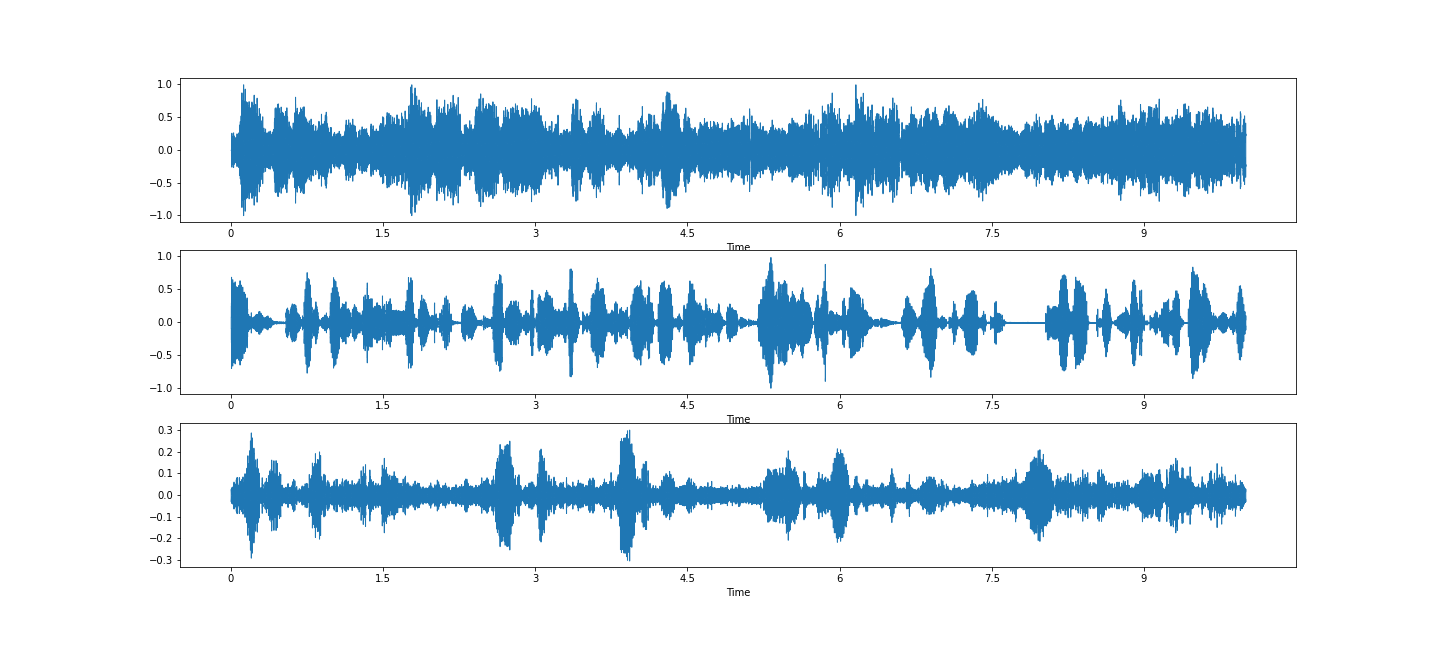

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,9))
lib_display.waveshow(sample1, sr=fs, ax=ax[0])
lib_display.waveshow(sample2, sr=fs, ax=ax[1])
lib_display.waveshow(sample3, sr=fs, ax=ax[2])
plt.show()


## DLTN Model

In [7]:
modelClass = DTLN_model();

# build the model in default configuration
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    modelClass.build_DTLN_model(norm_stft=True)

# load weights of the .h5 file
modelClass.model.load_weights("DTLN/pretrained_model/DTLN_norm_500h.h5")
model_dtln = modelClass.model

In [8]:
preds = []
for index, sample in enumerate([sample1, sample2, sample3]):
    pred = model_dtln(np.expand_dims(sample, 0))
    preds.append(pred)

    sf.write(f"pred{index+1}.wav", pred[0], fs, 'PCM_24')


In [9]:
def display_sound(index):
    """
    Print the current widget value in short sentence
    """
    display.display(display.Audio(samples[index-1], rate=fs))
    display.display(display.Audio(preds[index-1], rate=fs)) 

widgets.interact(display_sound, index=[1,2,3]);



interactive(children=(Dropdown(description='index', options=(1, 2, 3), value=1), Output()), _dom_classes=('wid…

## MetricGAN

In [11]:
enhance_model = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir="pretrained_models/metricgan-plus-voicebank",
)


In [12]:
preds_metricGAN = []
for index, sample in enumerate([sample1, sample2, sample3]):
    curr_sample = torch.from_numpy(np.expand_dims(sample, 0))
    pred = enhance_model.enhance_batch(curr_sample, lengths=torch.tensor([1.]))
    preds_metricGAN.append(pred)

    sf.write(f"pred{index+1}_MetricGAN.wav", pred[0], fs, 'PCM_24')


In [13]:
def display_sound(index):
    """
    Print the current widget value in short sentence
    """
    display.display(display.Audio(samples[index-1], rate=fs))
    display.display(display.Audio(preds_metricGAN[index-1], rate=fs)) 

widgets.interact(display_sound, index=[1,2,3]);

interactive(children=(Dropdown(description='index', options=(1, 2, 3), value=1), Output()), _dom_classes=('wid…